# Reinforcement for supply Chain

- Mehdi El Kansouli
- Victor Girou
- Samule Pariente

In this notebook we will developp an experiment to test the robustness of our model with respect to he observation it used to predict the action.

## Import 

In [7]:
from agent.DQN import ReplayBuffer, DQN
from environment.env import SupplyChainV0
import numpy as np
import torch
import matplotlib.pyplot as plt
from agent_trainer.main_trainer import training_dqn
from agent_trainer.utils import *

## Environment parameters

In [8]:
n_actions = 6
action_max_value = 200
single_possible_actions = [int(action_max_value/(n_actions-1))*i for i in range(n_actions)]

## Experiment 1

In [9]:
train_agent = False
n_distributors = 2

In [10]:
suppliers = {
    'distrib_'+str(k+1): {
    "demand": 100, 
    "stock_max": 200, 
    "stock_cost": 3.,
    "lost_sell": 3., 
    "transport_cost": lambda x: 0.5*x, 
    "sell_price": 5.
    }
    for k in range(n_distributors)}

env = SupplyChainV0(suppliers, 125*n_distributors)
env_eval = SupplyChainV0(suppliers, 125*n_distributors)

if train_agent:

    replay_buffer_capacity = 1e6
    D = ReplayBuffer(replay_buffer_capacity)

    # network parameters 
    obs_space_dim = n_distributors*2
    action_space_size = n_actions**n_distributors
    hidden_dim = 256

    model = DQN(action_space_dim=action_space_size, obs_space_dim=obs_space_dim, n_layers=2, layer_size=hidden_dim, learning_rate=3e-4)
    target_network = DQN(action_space_dim=action_space_size, obs_space_dim=obs_space_dim, n_layers=2, layer_size=hidden_dim, learning_rate=3e-4)
    target_network.load_state_dict(model.state_dict())

    trained_agent, losses, rewards = training_dqn(
        env=env,
        env_eval=env_eval,
        model=model,
        target_network=target_network,
        D=D,
        actions_discrete=single_possible_actions, 
        n_distributors=n_distributors,
        episode_length=100,
        gamma=0.9, 
        n_steps=100000, 
        tau=0.6,
        batch_size=32)
    torch.save(trained_agent, 'DQN_' + str(n_distributors) + '_distributors.pt')

    
    figs, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot([l.detach().numpy() for l in losses])
    axs[0].set_title('Evolution of the loss during training')
    axs[1].plot(np.arange(len(rewards)), rewards)
    axs[1].set_ylabel('Total Reward')
    axs[1].set_xlabel('Episodes')
    axs[1].set_title('Evolution of Reward during training')

In [11]:
model = torch.load('DQN_' + str(n_distributors) + '_distributors.pt')

In [12]:
episode_length = 100
reward_eval_dqn_list = []
profit_eval_dqn_list = [] 

for i in range(100):
    env_eval = SupplyChainV0(suppliers, 125*n_distributors)

    

    R = 0
    obs_eval, state_eval = env_eval.reset()
    terminated_eval = False
    profit_episode = []
    possible_actions = possible_actions_func(single_possible_actions, n_distributors)

    for _ in range(episode_length):

        with torch.no_grad():
            action_eval = torch.argmax(model(handle_obs_dict(obs_eval))).item()
            action_eval = possible_actions[action_eval]

        obs_eval, reward_eval, profit_eval = env_eval.step({'distrib_'+str(k+1): action_eval[k] for k in range(n_distributors)})
        R += reward_eval
        profit_episode.append(profit_eval)
    reward_eval_dqn_list.append(R)
    profit_eval_dqn_list.append(profit_episode)

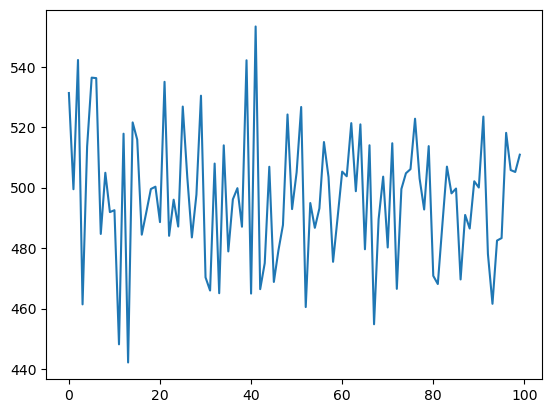

In [13]:
plt.plot(reward_eval_dqn_list)

## Experiment 2

In [14]:
n_distributors = 2
suppliers = {
        'distrib_'+str(k+1): {
        "demand": 100, 
        "stock_max": 200, 
        "stock_cost": 3.,
        "lost_sell": 3., 
        "transport_cost": lambda x: 0.5*x, 
        "sell_price": 5.
    }
    for k in range(n_distributors)}
noises = np.arange(5, 500, 20)

In [16]:

model = torch.load('DQN_'+str(n_distributors)+'_distributors.pt')
profit = {}
episode_length = 1000

for noise in noises:

    env_eval = SupplyChainV0(suppliers, 125*n_distributors, noise=noise)

    reward_eval_dqn_list = []
    profit_eval_dqn_list = []

    R = 0
    obs_eval, state_eval = env_eval.reset()
    terminated_eval = False
    profit_episode = []
    possible_actions = possible_actions_func(single_possible_actions, n_distributors)

    for _ in range(episode_length):

        with torch.no_grad():
            action_eval = torch.argmax(model(handle_obs_dict(obs_eval))).item()
            action_eval = possible_actions[action_eval]

        obs_eval, reward_eval, profit_eval = env_eval.step({'distrib_'+str(k+1): action_eval[k] for k in range(n_distributors)})
        R += reward_eval
        profit_episode.append(profit_eval)
    reward_eval_dqn_list.append(R)
    profit_eval_dqn_list.append(profit_episode)

    profit[noise] = profit_episode

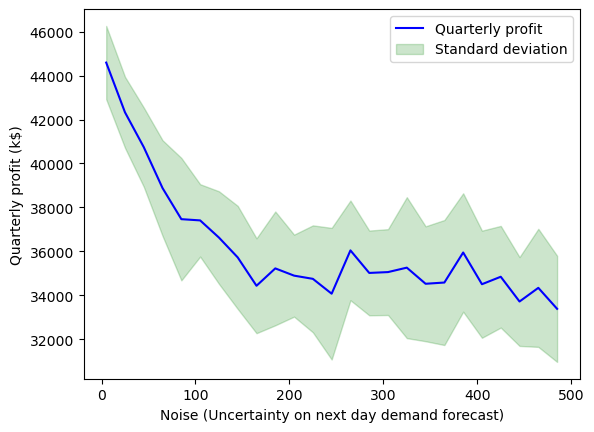

In [17]:
indicator_list = np.array([moving_average(np.array(val), 90) for val in profit.values()])
std_array = indicator_list[:, 1]
mean_array = indicator_list[:, 0]


plt.plot(noises, mean_array, color='blue', label='Quarterly profit')
plt.fill_between(noises, mean_array-std_array, mean_array+std_array, alpha=0.2, color='green', label='Standard deviation')
plt.xlabel('Noise (Uncertainty on next day demand forecast)')
plt.ylabel('Quarterly profit (k$)')
plt.legend()